# **Notebook des différentes approches de modélisation** : 




# **Sommaire** :     

[1.Préambule](#Pr)

[2.Algorithmes avec les features RFM](#Imports)
  - Calcul des features R,F et M
  - Segmentation quantile
  - K-means avec RFM
  - DBSCAN avec RFM

[3.Algorithmes de segmentation avec RFM + review_score ](#Db)
   - K-means 
   - DBSCAN 


[4.Algorithmes de segmentation avec plus de variables ](#Cb)
   - K-means avec plus de variables
   - DBSCAN avec plus de variables







<a name="Pr"></a>
# **1. Préambule**

*Voici les différentes méthodes utilisées dans ce Notebook :*


## Segmentation RFM : 


La [**segmentation RFM**](https://www.definitions-marketing.com/definition/segmentation-rfm/) (Recency, Frequency, Monetary) se base sur le comportement des acheteurs lors de leur dernières commandes pour les diviser en plusieurs catégories ou clusters. RFM permet d'identifier les bons des mauvais acheteurs.

En résumé :     

- RECENCY (R) : nombre de jours depuis la dernière commande

- FREQUENCY (F) : nombre de commandes

- MONETARY VALUE (M) : Argent total dépensé par le client

## Segmentation Quartile :

La [**segmentation quartile**](https://towardsdatascience.com/rfm-segmentation-using-quartiles-and-jenks-natural-breaks-924f4d8baee1) consiste à obtenir un pourcentage d'un feature(ici RFM) et de le rattacher à un quartile (de 1 à 4).

Ensuite il y a deux manières d'attribuer un score à un utilisateur, on peut soit creer un score de format "414" avec chaque chiffre correspondant aux scores respectifs de R,F et M.

On peut également additionner les scores de RFM. Au lieu de "414", on aurait un score de 9. Ici on choisit cette méthode car elle sera utilisée dans la segmentaion Kmeans pour attribuer les utilisateurs à une classe (Argent, Or, Bronze ou Platinium).

Cependant les limites de cet algorithme sont le fait qu'en additionant les scores de R,F et M on ne sait plus quelles sont leur valeurs et on a une perte d'informations. Avec un score de 11, on peut avoir RFM égaux à 3,4,4 ou 4,3,4 donc il faut prendre cette donnée en compte.

## Méthode des K-plus proches voisins :

La méthode des [**K-plus proches voisins**](https://medium.com/@kenzaharifi/bien-comprendre-lalgorithme-des-k-plus-proches-voisins-fonctionnement-et-impl%C3%A9mentation-sur-r-et-a66d2d372679#:~:text=Les%20'k%20plus%20proches%20voisins,de%20l'ensemble%20de%20test.) est une méthode de classification ou chaque donnée est affiliée à un groupe, ou cluster ayant un centre. 

Pour appliquer cette méthode, les étapes à suivre sont les suivantes :

- On fixe le nombre de voisins k.
- On détecte les k-voisins les plus proches des nouvelles données d’entrée   que l’on veut classer.
- On attribue les classes correspondantes par vote majoritaire.

## DBSCAN :

Le [**DBSCAN**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) est un algorithme simple qui définit des clusters en utilisant l’estimation de la densité locale. On peut le diviser en 4 étapes : 

Pour chaque observation on regarde le nombre de points à au plus une distance ε de celle-ci. On appelle cette zone le ε-voisinage de l’observation.

Si une observation compte au moins un certain nombre de voisins y compris elle-même, elle est considérée comme une observation cœur. On a alors décelé une observation à haute densité. 

Toutes les observations au voisinage d’une observation cœur appartiennent au même cluster. Il peut y avoir des observations cœur proche les unes des autres. Par conséquent de proche en proche on obtient une longue séquence d’observations cœur qui constitue un unique cluster. 

Toute observation qui n’est pas une observation cœur et qui ne comporte pas d’observation cœur dans son voisinage est considérée comme une anomalie.

<a name="Imports"></a>
# **2. Algorithmes avec les features RFM**



### On importe les librairies nécessaires

In [1]:
from sklearn.metrics import adjusted_rand_score

from sklearn.metrics import davies_bouldin_score

from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

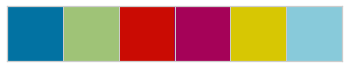

In [2]:
import datetime as dt

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer




current_palette = sns.color_palette()

sns.palplot(current_palette)



In [3]:
use_colab = True 

if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path ='/content/drive/MyDrive/'
else:
    path='/data/'

data = pd.read_csv(path + 'Segmentation_Clean.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data.head()

,Unnamed: 0,customer_unique_id,customer_state,harvesine_distance,order_id,order_delivered_customer_date,review_score,payment_sequential,payment_type,payment_installments,payment_value,product_id,seller_id,price,product_photos_qty,product_weight_g,product_category_name_french,volume,delay
0,0,861eff4711a542e4b93843c6dd7febb0,SP,361.006047,00e7ee1b050b8499577073aeb2a297a1,2017-05-25 10:35:35,4,1,credit_card,2,146.87,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,1.0,8683.0,mobilier de bureau,107136.0,8 days 19:13:23
1,2,452fab1c62b178922fc011b0eb89c1b9,BA,960.287330,a4866dfc455353f48014a2b9a86608a2,2018-02-14 13:09:54,4,1,boleto,1,340.50,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,126.99,1.0,8683.0,mobilier de bureau,107136.0,33 days 20:14:16
2,3,613259d64ba972e49dc25b019b7918c3,SP,202.794320,03afb3c10af52ddfa3c33b9881bf43f8,2017-12-18 18:10:28,4,1,credit_card,2,131.50,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,112.99,1.0,8683.0,mobilier de bureau,107136.0,11 days 01:18:31
3,5,aaad33c5051196b5e73c7d65b9072e1d,MG,348.729613,3c75044db750a89606612ed286713eb8,2018-04-03 02:42:11,3,1,credit_card,7,74.07,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,116.99,1.0,8683.0,mobilier de bureau,107136.0,20 days 05:52:47
4,6,35c0fa6f2e6bbb3576e725d22e1066b8,RJ,396.113519,edc9338008f2e9017f842a8bcad3af94,2017-05-16 16:04:47,5,1,voucher,1,140.03,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,1.0,8683.0,mobilier de bureau,107136.0,17 days 22:54:35



## *Segmentation RFM*

### On importe le jeu de données

In [5]:
data = data.drop(columns = ['Unnamed: 0'])

In [6]:
data_copy = data.copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94236 entries, 0 to 94235
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_unique_id             94236 non-null  object 
 1   customer_state                 94236 non-null  object 
 2   harvesine_distance             94236 non-null  float64
 3   order_id                       94236 non-null  object 
 4   order_delivered_customer_date  94236 non-null  object 
 5   review_score                   94236 non-null  int64  
 6   payment_sequential             94236 non-null  int64  
 7   payment_type                   94236 non-null  object 
 8   payment_installments           94236 non-null  int64  
 9   payment_value                  94236 non-null  float64
 10  product_id                     94236 non-null  object 
 11  seller_id                      94236 non-null  object 
 12  price                          94236 non-null 

On regarde la date de la dernière commande passée ainsi que celle de la première commande.

In [8]:
#dernière date disponible dans le dataset

data['order_delivered_customer_date'].max()

'2018-10-17 13:22:46'

In [9]:
data['order_delivered_customer_date'].min()

'1970-01-01 00:00:00'

In [10]:
now = dt.date(2018,10,17)

print(now)

2018-10-17


On établit un modèle de scoring allant de 1 à 5. Il existe plusieurs méthodes de scoring. Le premier est sous un format "414" avec chaque chiffre correspondant au score de RFM. La deuxième, qu'on utilisera ici (plus pratique avec K-means), additionne les scores de RFM. Le score obtenu est une variable numérique qui sera facile à utiliser ensuite.

On calclule un score global sur 15, on a ensuite quatre grades de scoring :

- Bronze : mauvais clients
- Argent : bons clients 
- Or : très bons clients
- Platinium : excellents clients

In [11]:
def rfm_level(score):
    if (score <= 0):
        return 'Erreur'
    elif (score <= 5):
        return 'Bronze'
    elif (score <= 8):
        return 'Argent'
    elif (score <= 11):
        return 'Or'
    elif (score <= 16):
        return 'Platinium'
    else:
        return 'Erreur'

In [12]:
data['date'] = pd.DatetimeIndex(data['order_delivered_customer_date']).date

In [13]:
data_copy['date'] = pd.DatetimeIndex(data_copy[
          'order_delivered_customer_date']).date

In [14]:
now = dt.date(2018, 10, 17)

La fonction RFM va effectuer la segmentation quartile avec les variables R,F et M et attribuer un score à chaque client.

In [15]:
def RFM(data,now):

    
    #RECENCY

    recency_df = data.groupby(by ='customer_unique_id',
                          as_index = False)['date'].max()

    recency_df.columns = ['customer_unique_id','LastPurchaseDate']


    recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x:
                                                                (now - x).days)
    


    recency_df.drop('LastPurchaseDate',axis=1,inplace=True)

    data_copy = data

    data_copy.drop_duplicates(subset=['order_id', 'customer_unique_id'], 
                                            keep="first", inplace=True)
    
    # FREQUENCY

    frequency_df = data_copy.groupby(by=['customer_unique_id'],
                            as_index=False)['order_id'].count()

    frequency_df.columns = ['customer_unique_id','Frequency']

    data['TotalCost'] = data['price'] 

    # MONETARY


    monetary_df = data.groupby(by ='customer_unique_id',
              as_index=False).agg({'TotalCost': 'sum'})

    monetary_df.columns = ['customer_unique_id','Monetary']

    temp_df = recency_df.merge(frequency_df,on ='customer_unique_id')

    temp_df.head()

    data_review = data[['customer_unique_id', 'review_score']]

    temp_df = temp_df.merge(data_review,on='customer_unique_id')

    rfm_df = temp_df.merge(monetary_df,on='customer_unique_id')

    rfm_df.set_index('customer_unique_id',inplace=True)

    rfm_df.head()

    rfm_maintenance = rfm_df.copy()

    rfm_maintenance.head()


    
    # SEGMENTATION QUARTILE

    quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])

    quantiles.to_dict()


    # MISE EN PLACE DU SCORING

    rfm_segmentation = rfm_df

    rfm_segmentation["recency_score"] = pd.qcut(rfm_segmentation['Recency'],
                                                  5, labels=[5, 4, 3, 2, 1])


    rfm_segmentation["frequency_score"] = pd.qcut(
    rfm_segmentation['Frequency'].rank(method ="first"), 5,
                                   labels = [1, 2, 3, 4, 5])

    rfm_segmentation["monetary_score"] = pd.qcut(rfm_segmentation['Monetary'],
                                                    5, labels = [1, 2, 3, 4, 5])
    

    rfm_segmentation['score'] = rfm_segmentation[
    'recency_score'].astype(int) + rfm_segmentation['frequency_score'
    ].astype(int) + rfm_segmentation['monetary_score'].astype(int)

    data = pd.merge(data,rfm_segmentation, how ='inner',
    left_on = ['customer_unique_id'], right_on = ['customer_unique_id'])

    rfm_segmentation[rfm_segmentation['score'] == 15].sort_values(
                              'Monetary', ascending=False).head()

    scaler = StandardScaler()

    rfm_segmentation_bis = pd.DataFrame(scaler.fit_transform(
        rfm_segmentation),columns = rfm_segmentation.columns)


  

    rfm_segmentation['level'] = rfm_segmentation['score'].apply(
                                lambda score : rfm_level(score)) 
    

    plt.figure(figsize=(10,5))
    sns.set_context("poster", font_scale=0.7)
    sns.set_palette('twilight')
    sns.countplot(rfm_segmentation['level'])
    rfm_segmentation.groupby('level').agg({
    
    'Recency' : ['mean', 'min','max'],
    'Frequency' : ['mean', 'min','max'],
    'Monetary' : ['mean','min','max','count']
    
    })

    # ATTRIBUTION DES GRADES AUX CLIENTS

    Bronze = rfm_segmentation[rfm_segmentation['level'] == 'Bronze']

    Argent = rfm_segmentation[rfm_segmentation['level'] == 'Argent']

    Or = rfm_segmentation[rfm_segmentation['level'] == 'Or']

    Platinium = rfm_segmentation[rfm_segmentation['level'] == 'Platinium']

    print("Clients avec le grade Bronze: ",len(Bronze))

    print('Clients avec le grade Argent: ',len(Argent))

    print('Clients avec le grade Or: ', len(Or))

    print('Clients avec le grade Platinium: ', len(Platinium))

    return rfm_segmentation
    return rfm_segmentation_bis  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Clients avec le grade Bronze:  8112
Clients avec le grade Argent:  32473
Clients avec le grade Or:  37525
Clients avec le grade Platinium:  16126


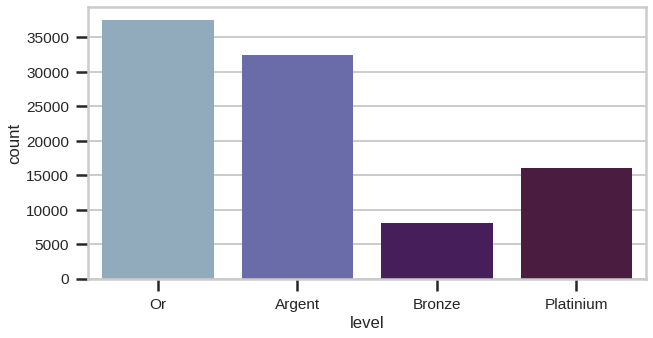

In [16]:
rfm_segmentation=RFM(data=data,now=now)

Dans le cadre de l'étude de la stabilité des clusters plus tard dans un autre notebook, on va restreindre le dataset sur une année et l'exporter en format csv. On le fait à une date définie par la variable "now" qui aura une valeur différente en fonction de l'intervalle de temps que l'on veut visionner.

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarn

Clients avec le grade Bronze:  3651
Clients avec le grade Argent:  14819
Clients avec le grade Or:  17395
Clients avec le grade Platinium:  7186


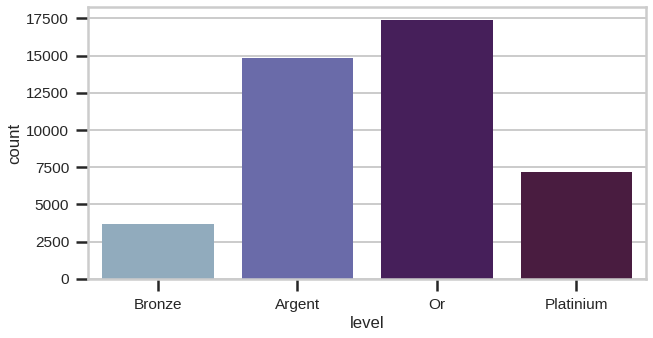

In [17]:
now = dt.date(2018,1,17)

mask = (data['date'] < now) 

df = data.loc[mask]

rfm_export=RFM(data = df,now = now)

rfm_export = rfm_export[['Recency','Frequency','Monetary','review_score']]

rfm_export.to_csv("/content/drive/MyDrive/rfm_export.csv")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarn

Clients avec le grade Bronze:  7068
Clients avec le grade Argent:  28759
Clients avec le grade Or:  33183
Clients avec le grade Platinium:  14137


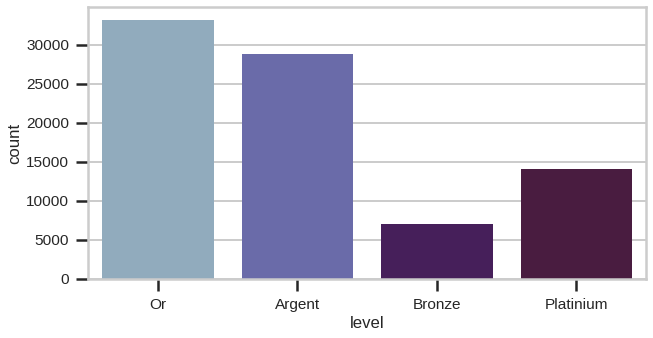

In [18]:
now = dt.date(2018,7,17)

mask = (data['date'] < now) 

df_bis = data.loc[mask]

rfm_export_bis=RFM(data = df_bis,now = now)

rfm_export_bis = rfm_export_bis[['Recency','Frequency','Monetary','review_score']]

rfm_export_bis.to_csv("/content/drive/MyDrive/rfm_export_bis.csv")

On observe la répartition des clients en fonction de leur score sur le graphique ci-dessous

Maintenant qu'on a segmenté nos clients, on peut travailler sur chaque groupe :

- Excellents clients :  On peut les récompenser et les faire tester de nouveaux produits.

- Clients moyens : les encourager à acheter des produits avec des campagnes publicitaires par mail.

In [19]:
outlier = rfm_segmentation.loc[rfm_segmentation['Recency'] >= 10000]

rfm_segmentation = rfm_segmentation.drop(outlier.index)

In [20]:
rfm_segmentation.sort_values('Recency')

,Recency,Frequency,review_score,Monetary,recency_score,frequency_score,monetary_score,score,level
customer_unique_id,,,,,,,,,
fc0bcca3d8d90a812b707bb8e45069d6,0,1,4,26.40,5,5,1,11,Or
232422c2db1f7c69daf3b0f0421ebb43,6,1,5,179.00,5,1,5,11,Or
4bc530761c1b59d33d7c6cb640d3ee78,15,1,5,70.00,5,2,3,10,Or
3ae68a873484afec224de126a94c5974,20,1,1,209.99,5,2,5,12,Platinium
c9f2b70eaddf459267a9de373aaf743b,22,1,1,49.90,5,4,2,11,Or
...,...,...,...,...,...,...,...,...,...
ee1b69039bd20877692d8622dedbc3ec,734,1,5,279.90,1,5,5,11,Or
faae4bdf680651e40005ea6f0f90e8b8,734,1,3,49.90,1,5,2,8,Argent
664f7107c351f24b16b68919398730a0,734,1,1,294.90,1,2,5,8,Argent


## *K-means avec RFM :*

In [21]:
rfm = rfm_segmentation[['Recency','Frequency','Monetary']]

In [22]:
scaler = StandardScaler()

x_scaled = scaler.fit(rfm)
x_scaled = scaler.fit_transform(rfm)

In [23]:
rfm.describe()

,Recency,Frequency,Monetary
count,94228.000000,94228.000000,94228.000000
mean,272.570107,1.074012,132.913687
std,151.726677,0.362468,197.765439
min,0.000000,1.000000,0.850000
25%,152.000000,1.000000,44.900000
50%,252.000000,1.000000,81.090000
75%,380.000000,1.000000,149.000000
max,736.000000,14.000000,7388.000000


Nos trois métriques pour la selection du nombre optimal de clusters sont :

- Le coefficient de Silhouette
- Le score de Davies Bouldin
- La méthode du Coude

La [méthode du coude](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) : elle consiste à calculer la variance des différents volumes de clusters envisagés, puis à placer les variances obtenues sur un graphique. On obtient alors une visualisation en forme de coude (elbow en anglais), sur laquelle le nombre optimal de clusters est le point représentant la pointe du coude, c'est-à-dire celui correspondant au nombre de clusters à partir duquel la variance ne baisse plus significativement.

Ici on observe que l'idéal est d'avoir 4 clusters.

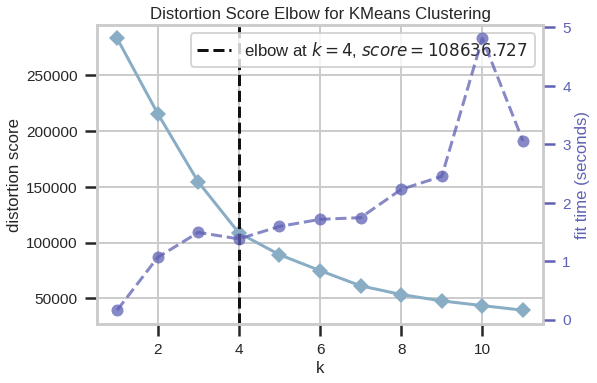

In [24]:
model = KMeans()

visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(x_scaled)  

visualizer.show()   

[1 1 0 ... 0 1 0]
 Our cluster centers are as follows
[[-0.69142109 -0.20418998 -0.15124071]
 [ 1.03153632 -0.20418998 -0.15481502]
 [-0.01549106 -0.04556867  4.50516522]
 [-0.12112211  3.1795449   0.39396962]]


,Recency,Frequency,Monetary
cluster_pred,,,
0,51225,51225,51225
1,34992,34992,34992
2,2439,2439,2439
3,5572,5572,5572


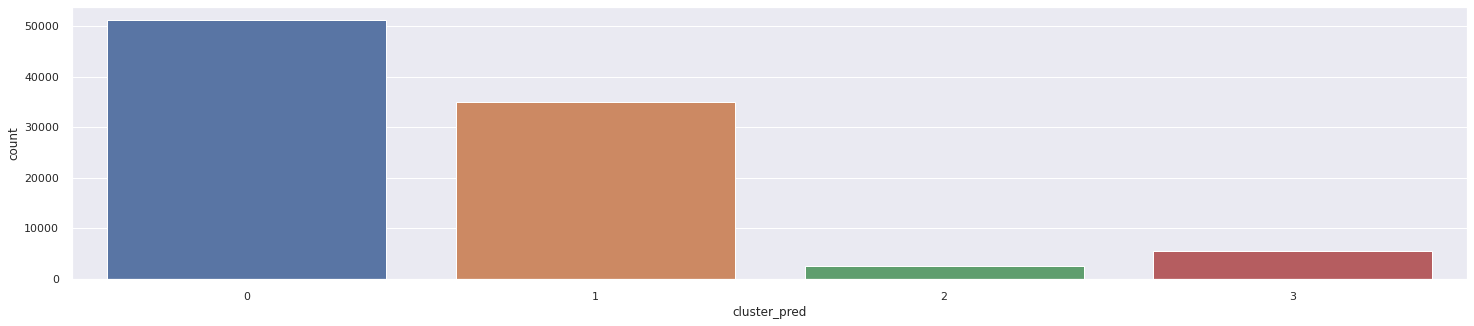

In [25]:
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled)

identified_clusters = kmeans_scaled.fit_predict(rfm)
clusters_scaled = rfm.copy()
clusters_scaled['cluster_pred'] = kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)

sns.set(style = "darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x = "cluster_pred", data = clusters_scaled)

clusters_scaled.groupby(['cluster_pred']).count()

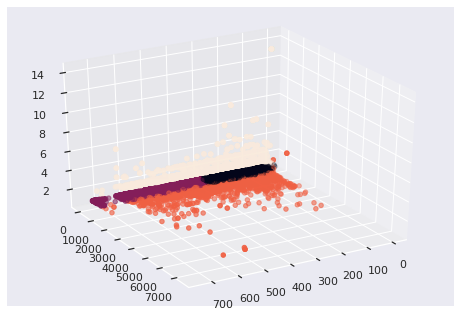

In [26]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

xline = clusters_scaled['Recency']
yline = clusters_scaled['Frequency']
zline = clusters_scaled['Monetary']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(30, 60)

Le score de [**Davies-Bouldin**](https://runebook.dev/fr/docs/scikit_learn/modules/generated/sklearn.metrics.davies_bouldin_score)  est défini comme la mesure de similarité moyenne de chaque cluster avec son cluster le plus similaire, plus il est proche de zéro, mieux il est.

In [27]:
range_n_clusters = [ 3, 4, 5]

for num_clusters in range_n_clusters:
    
    #intialisation de kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter = 50)
    kmeans.fit(x_scaled)
    
    
    #silhouette score
    davies_avg = davies_bouldin_score(x_scaled, kmeans.labels_)
    print("For n_clusters={0}, the davies_bouldin score is {1}".format(
        num_clusters, round(davies_avg,2)))

For n_clusters=3, the davies_bouldin score is 1.01
For n_clusters=4, the davies_bouldin score is 0.74
For n_clusters=5, the davies_bouldin score is 0.71


En partitionnement de données, le [**coefficient de silhouette**](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c) (Silhouette score) est une mesure de qualité d'une partition d'un ensemble de données. Il est compris en -1 et 1 et plus sa valeur se rapproche de 1, mieux le clustering est.


[**Le tracé de la silhouette**]( https://runebook.dev/fr/docs/scikit_learn/auto_examples/cluster/plot_kmeans_silhouette_analysis) permet de voir la distance entre les différents clusters.

Le tracé de la silhouette affiche une mesure de la proximité de chaque point d'un cluster par rapport aux points des clusters voisins et fournit ainsi un moyen d'évaluer visuellement des paramètres tels que le nombre de clusters.Cette mesure a une plage de [-1,1]. 

In [28]:
range_n_clusters = [3, 4, 5]

for num_clusters in range_n_clusters:
    
    #intialisation de kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(x_scaled)
    
    
    #silhouette score
    silhouette_avg = silhouette_score(x_scaled, kmeans.labels_)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters,
                                                     round(silhouette_avg,2)))

For n_clusters=3, the silhouette score is 0.46
For n_clusters=4, the silhouette score is 0.49
For n_clusters=5, the silhouette score is 0.49


Silhouette Score: 0.490


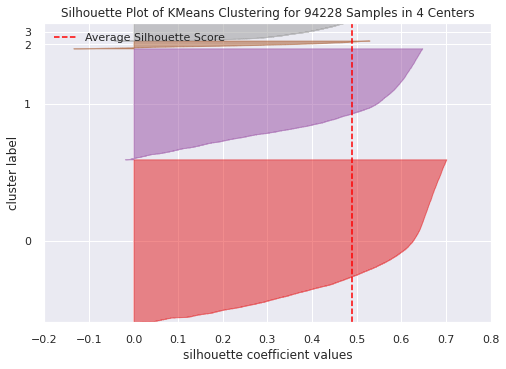

In [29]:
sil_score = silhouette_score(x_scaled, kmeans_scaled.labels_,metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model= KMeans(4)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled)   
visualizer.poof()   

Silhouette Score: 0.490


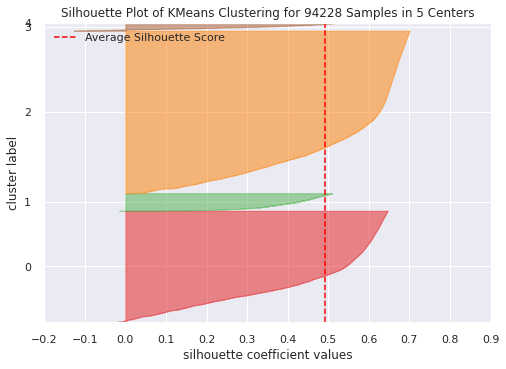

In [30]:
sil_score = silhouette_score(x_scaled, kmeans_scaled.labels_,
                             metric='euclidean')

print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(5)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled)   
visualizer.poof()   

En se basant les [différences](https://vitalflux.com/elbow-method-silhouette-score-which-better/#:~:text=The%20major%20difference%20between%20elbow,high%2Dlow%20differences%2C%20etc.) entre les méthodes du coude, le coefficient
de silhouette, et le score de Davies-Bouldin, on en conclut que le nombre idéal de clusters serait de 4.

In [31]:
rfm['cluster']= clusters_scaled['cluster_pred']


cluster_group = rfm.groupby('cluster').agg({
    'Recency' : ['mean','min','max'],
    'Frequency' : ['mean','min','max'],
    'Monetary' : ['mean','min','max','count']
   #'review_score' : ['mean','min','max','count']
})

display(cluster_group)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Recency           Frequency             Monetary                   \
               mean  min  max      mean min max         mean     min      max   
cluster                                                                         
0        167.716545    0  298  1.000000   1   1   102.943068    0.85   590.00   
1        429.156321  299  736  1.000000   1   1   102.330033    2.29   649.17   
2        270.215662   35  730  1.057401   1   4  1023.153944  559.00  7388.00   
3        254.192749   34  721  2.226490   2  14   210.826849   11.98  1535.40   

                
         count  
cluster         
0        51225  
1        34992  
2         2439  
3         5572

In [32]:
rfm.head()

,Recency,Frequency,Monetary,cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90,0
0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90,0
0000f46a3911fa3c0805444483337064,560,1,69.00,1
0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99,1
0004aac84e0df4da2b147fca70cf8255,324,1,180.00,1


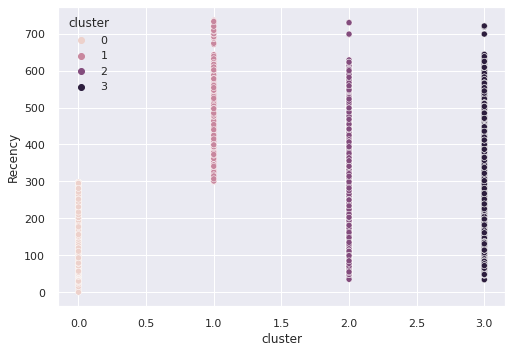

In [33]:
sns.scatterplot(data = rfm, x = "cluster", y = "Recency", hue = "cluster")

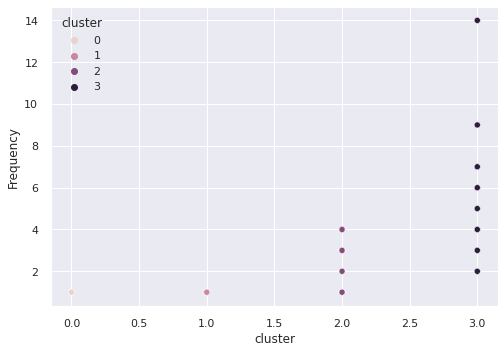

In [34]:
sns.scatterplot(data = rfm, x = "cluster", y = "Frequency", hue = "cluster")

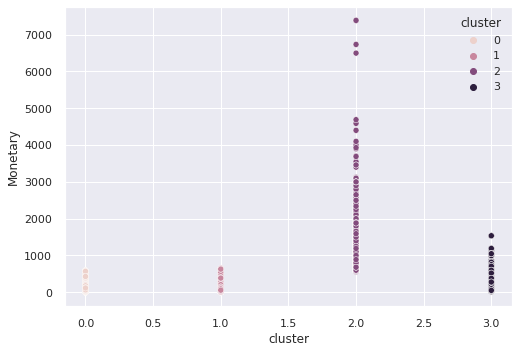

In [35]:
sns.scatterplot(data = rfm, x = "cluster", y = "Monetary", hue = "cluster")

In [36]:
display(cluster_group)

Recency           Frequency             Monetary                   \
               mean  min  max      mean min max         mean     min      max   
cluster                                                                         
0        167.716545    0  298  1.000000   1   1   102.943068    0.85   590.00   
1        429.156321  299  736  1.000000   1   1   102.330033    2.29   649.17   
2        270.215662   35  730  1.057401   1   4  1023.153944  559.00  7388.00   
3        254.192749   34  721  2.226490   2  14   210.826849   11.98  1535.40   

                
         count  
cluster         
0        51225  
1        34992  
2         2439  
3         5572

- Le cluster 0 contient 34984 clients. Ils sont peu dépensiers, peu fidèles et n'ont pas commandé depuis longtemps. Ce sont des clients perdus.

- Le cluster 1 contient 51215 clients. Ils sont peu dépensiers, peu fidèles mais ont commandés recemment. Ce sont des clients potentiels pour l'avenir.

- Le cluster 2 contient 5572 clients. Ils sont peu dépensiers mais plus que les clusters 0 et 1. Cependant les commandes sont nombreuses et les clients de ce clusters sont fidèles.

- Le cluster 3 contient 2457 clients donc peu de clients. Ce sont les meilleurs clients car ils sont les plus dépensiers.

Cependant, vu que le review_score n'est pas présent, et qu'on doit prendre en compte la satisfaction des clients, cette segmentation KMeans RFM nous est inutile. On l'a utilisée ici dans un contexte baseline.

De plus le silhouette score est de 0.49 pour nos 4 clusters, ce qui est dans l'ensemble un mauvais résultat.

In [37]:
cluster_1 = rfm.loc[rfm['cluster'] == 1].sample(1000)
cluster_0 = rfm.loc[rfm['cluster'] == 0].sample(1000)
cluster_3 = rfm.loc[rfm['cluster'] == 3].sample(1000)
cluster_2 = rfm.loc[rfm['cluster'] == 2].sample(1000)

In [38]:
cluster = pd.concat([cluster_0, cluster_1], axis = 0)
cluster = pd.concat([cluster, cluster_2], axis = 0)
cluster = pd.concat([cluster, cluster_3], axis = 0)


In [39]:
rfm_scaled = pd.DataFrame()
rfm_scaled = rfm.copy()

scaler = StandardScaler()

rfm_scaled[['Recency', 'Frequency','Monetary']] = scaler.fit_transform(
    rfm_scaled[['Recency', 'Frequency','Monetary']])

rfm_scaled['cust_id'] = rfm.index

rfm_melted = pd.melt(frame = rfm_scaled, id_vars= ['cust_id', 'cluster']
                     , var_name = 'metrics', value_name = 'value')
rfm_melted.head()

,cust_id,cluster,metrics,value
0,0000366f3b9a7992bf8c76cfdf3221e2,0,Recency,-0.781476
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,Recency,-0.741931
2,0000f46a3911fa3c0805444483337064,1,Recency,1.894403
3,0000f6ccb0745a6a4b88665a16c9f078,1,Recency,0.510328
4,0004aac84e0df4da2b147fca70cf8255,1,Recency,0.338966


Les évolutions des clusters de la segmentation RFM baseline et de la segmentation K-means sont différentes.

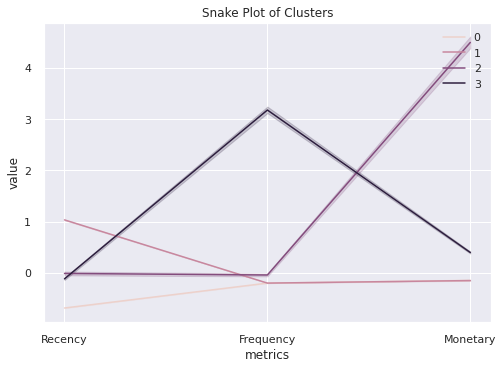

In [40]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'cluster', data = rfm_melted)
plt.title('Snake Plot of Clusters')
plt.legend(loc = 'upper right')

On va faire une visualisation [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 

In [41]:
from sklearn.manifold import TSNE # TSNE module
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 2000)
tsne_results = tsne.fit_transform(cluster)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.004s...
[t-SNE] Computed neighbors for 4000 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 16.952462
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.177879
[t-SNE] KL divergence after 2000 iterations: 0.526115


In [42]:
#creating a new dataframe including target
target = cluster['cluster']
new_df_tsne = pd.DataFrame(np.hstack((tsne_results,
np.array(target).reshape(-1,1))),
columns = ['1st_component','2nd_component','Cluster'])
new_df_tsne.head()

,1st_component,2nd_component,Cluster
0,13.061326,-8.658853,0.0
1,59.757454,-28.786215,0.0
2,14.283178,-16.978931,0.0
3,52.257832,-11.490730,0.0
4,58.769547,26.858770,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


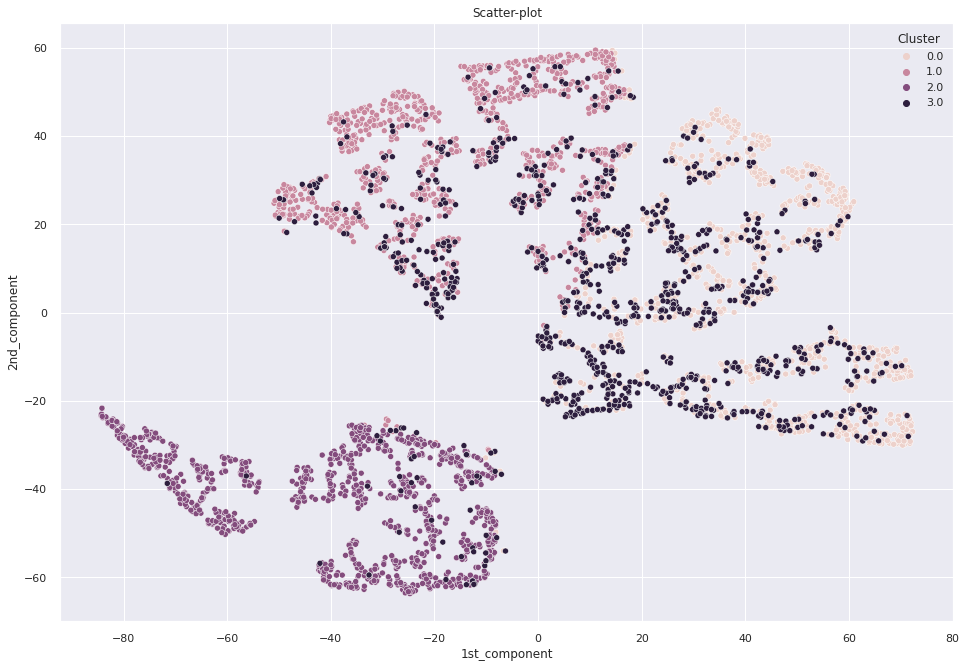

In [43]:
plt.figure(figsize = (16,11))
sns.scatterplot(new_df_tsne['1st_component'],new_df_tsne['2nd_component'],
                hue = new_df_tsne['Cluster'])
plt.title('Scatter-plot')
plt.show()

## *DBSCAN avec RFM*

In [44]:
X1 = rfm_segmentation[['Recency','Frequency','Monetary']]
X1 = StandardScaler().fit_transform(X1)
from sklearn import metrics

In [45]:
from sklearn.datasets import make_blobs



centers = [[1, 1], [-1, -1], [1, -1]]
X1, labels_true = make_blobs(n_samples = 750, centers=centers, cluster_std = 0.4,
                            random_state = 0)

On utilise ici la [méthode du coude](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc) pour déterminer epsilon. Quant au [min_samples](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd), il est égal à minimum au double du nombre de features.

In [46]:
from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt

In [47]:
neighbors = NearestNeighbors(n_neighbors=2)

neighbors_fit = neighbors.fit(X1)

distances, indices = neighbors_fit.kneighbors(X1)

Le nombre epsilon idéal est de 0.15

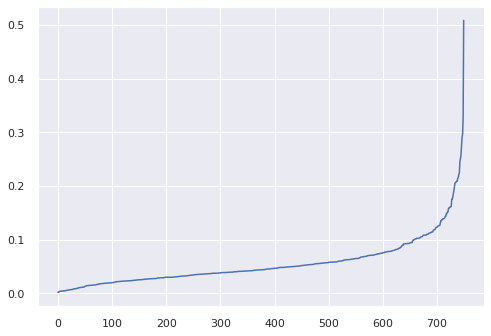

In [48]:
distances = np.sort(distances, axis=0)

distances = distances[:,1]

plt.plot(distances)

Estimated number of clusters: 5
Estimated number of noise points: 129
Homogeneity: 0.828
Completeness: 0.630
V-measure: 0.715
Adjusted Rand Index: 0.702
Adjusted Mutual Information: 0.714
Silhouette Coefficient: 0.342


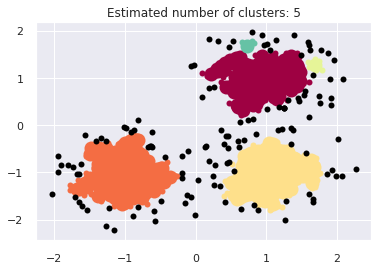

In [49]:
#Application de DBSCAN

db = DBSCAN(eps = 0.15, min_samples = 6).fit(X1)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Nombre de clusters dans les labels, on ignore le bruit.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X1, labels))

# Plot le résultat
import matplotlib.pyplot as plt
%matplotlib inline

# Couleur noire utilisée pour le bruit.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X1[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X1[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

- Homogeneité : On définit ainsi l’homogénéité (notée Tk pour tightness en anglais) d’un cluster comme la moyenne des distances de chacun des points contenus dans ce cluster au centroïde μk

- Silouhette Coefficient : L’autre moyen de quantifier à quel point un clustering répond à ces deux exigences (homogénéité et séparation) est de mesurer le coefficient de silhouette. Pour un point x donné, le coefficient de silhouette s(x) permet d’évaluer si ce point appartient au « bon » cluster

- Complétion : si les points d'une classe apartiennent au meme cluster

- Noise points : points n'appartenant à aucun cluster

- V-Measure : Appelé aussi Normalised Mutual Information, entre 0 et 1 et mesure l'efficacité du clustering en se basant sur l'homogénéité et la complétion

- L'indice de Rand : est une mesure de similarité entre deux partitions d'un ensemble. Il est principalement utilisé en catégorisation automatique. Son principe est de mesurer la consistance (le taux d'accord) entre deux partitions.

On observe que le coefficient de Silhouette est plus bas avec DBSCAN.

Dans le cas d'une segmentation RFM, les solutions les plus adaptées sont la segmentation quantile ou la segmentation K-Means.

<a name="Db"></a>
# **3. Algorithmes avec les features RFM + review_score**


## *K-means avec RFM plus review_score :*

In [50]:
rfm_rev = rfm_segmentation[['Recency','Frequency','Monetary','review_score']]

scaler = StandardScaler()

x_scaled_rev =  scaler.fit(rfm_rev)
x_scaled_rev = scaler.fit_transform(rfm_rev)

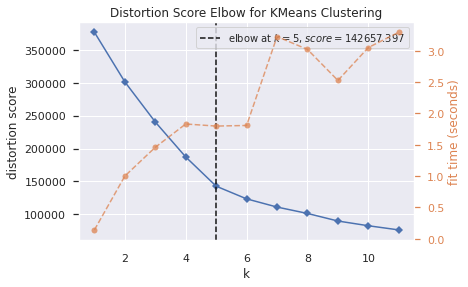

In [51]:
model = KMeans()

visualizer = KElbowVisualizer(model, k = (1,12))

visualizer.fit(x_scaled_rev)  

visualizer.show()   

[1 1 0 ... 0 1 0]
 Our cluster centers are as follows
[[-0.7207536  -0.20418998 -0.1426628   0.43334473]
 [-0.10262378 -0.20418998 -0.12626213 -1.87710797]
 [-0.0258703  -0.00570957  5.03168625  0.04446324]
 [ 1.06362183 -0.20418998 -0.13857492  0.3730935 ]
 [-0.12159686  3.17772406  0.39443763  0.0512222 ]]


,Recency,Frequency,Monetary,review_score
cluster_pred,,,,
0,40999,40999,40999,40999
1,15639,15639,15639,15639
2,1951,1951,1951,1951
3,30064,30064,30064,30064
4,5575,5575,5575,5575


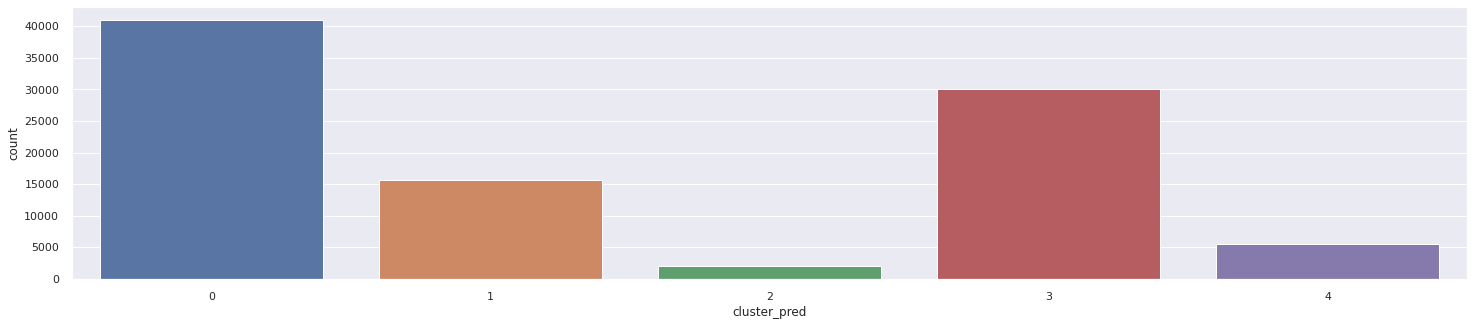

In [52]:
kmeans_scaled = KMeans(5)
kmeans_scaled.fit(x_scaled_rev)
identified_clusters = kmeans_scaled.fit_predict(rfm_rev)
clusters_scaled = rfm_rev.copy()
clusters_scaled['cluster_pred'] = kmeans_scaled.fit_predict(x_scaled_rev)
print(identified_clusters)

sns.set(style = "darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize = (25, 5))
ax = sns.countplot(x ="cluster_pred", data = clusters_scaled)

clusters_scaled.groupby(['cluster_pred']).count()

In [53]:
range_n_clusters = [ 4, 5, 6]

for num_clusters in range_n_clusters:
    
    #intialisation de kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(x_scaled_rev)
    
    #silhouette score
    davies_avg = davies_bouldin_score(x_scaled_rev, kmeans.labels_)
    print("For n_clusters={0}, the davies_bouldin score is {1}".format(
    num_clusters, round(davies_avg,2)))

For n_clusters=4, the davies_bouldin score is 1.08
For n_clusters=5, the davies_bouldin score is 0.83
For n_clusters=6, the davies_bouldin score is 0.77


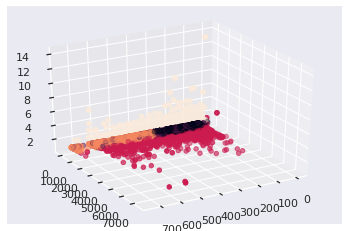

In [54]:
fig = plt.figure()
ax = plt.axes(projection='3d')

xline = clusters_scaled['Recency']
yline = clusters_scaled['Frequency']
zline = clusters_scaled['Monetary']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(30, 60)

In [55]:
range_n_clusters = [4, 5, 6]

for num_clusters in range_n_clusters:
    
    #intialisation de kmeans
    kmeans = KMeans(n_clusters = num_clusters, max_iter=50)
    kmeans.fit(x_scaled_rev)
    
    
    #silhouette score
    silhouette_avg = silhouette_score(x_scaled_rev, kmeans.labels_)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters,
                                                       round(silhouette_avg,2)))

For n_clusters=4, the silhouette score is 0.39
For n_clusters=5, the silhouette score is 0.41
For n_clusters=6, the silhouette score is 0.41


Silhouette Score: 0.410


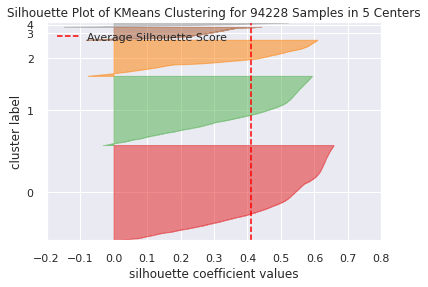

In [56]:
sil_score = silhouette_score(x_scaled_rev, kmeans_scaled.labels_,
                             metric = 'euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled_rev)   
visualizer.poof()   

Silhouette Score: 0.410


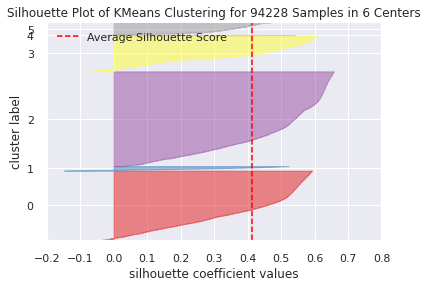

In [57]:
sil_score = silhouette_score(x_scaled_rev, kmeans_scaled.labels_, 
                             metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(6)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled_rev)   
visualizer.poof()   

En se basant sur nos trois métriques, le nombre optimal de clusters est de 5.

In [58]:
rfm_rev['cluster'] = clusters_scaled['cluster_pred']


cluster_count = rfm_rev.groupby('cluster').agg({
    'Recency' : ['mean','min','max'],
    'Frequency' : ['mean','min','max'],
    'Monetary' : ['mean','min','max','count'],
   'review_score' : ['mean','min','max','count']
})

display(cluster_count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Recency           Frequency             Monetary                   \
               mean  min  max      mean min max         mean     min      max   
cluster                                                                         
0        163.035757    0  300  1.000000   1   1   104.711139    0.85   650.00   
1        257.020717   20  734  1.000000   1   1   107.910085    0.85   730.00   
2        268.471553   35  730  1.071758   1   4  1126.729692  599.65  7388.00   
3        433.720563  297  736  1.000000   1   1   105.422025    2.29   689.99   
4        254.120717   34  721  2.225830   2  14   210.919404   11.98  1535.40   

               review_score                 
         count         mean min max  count  
cluster                                     
0        40999     4.712944   3   5  40999  
1        15639     1.748194   1   3  15639  
2         1951     4.213737   1   5   1951  
3        30064     4.636675   2   5  30064  
4         5575     4.222960   1   5   5575

In [59]:
rfm_rev.head()

,Recency,Frequency,Monetary,review_score,cluster
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90,5,0
0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90,4,0
0000f46a3911fa3c0805444483337064,560,1,69.00,3,3
0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99,4,3
0004aac84e0df4da2b147fca70cf8255,324,1,180.00,5,3


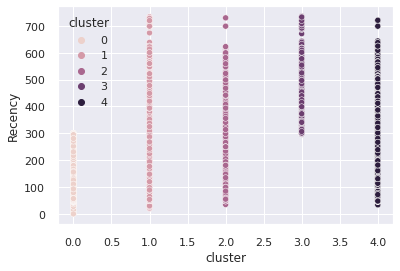

In [60]:
sns.scatterplot(data = rfm_rev, x = "cluster", y = "Recency", hue = "cluster")

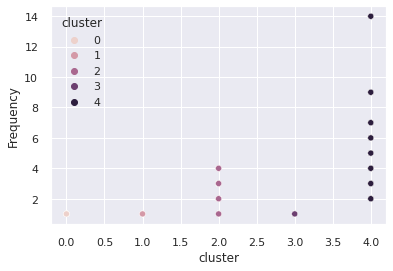

In [61]:
sns.scatterplot(data = rfm_rev, x = "cluster", y = "Frequency", hue = "cluster")

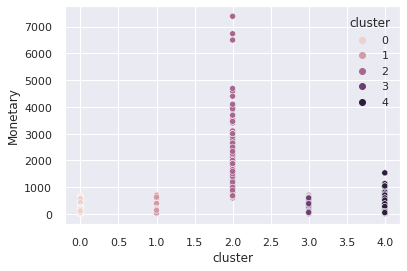

In [62]:
sns.scatterplot(data = rfm_rev, x = "cluster", y = "Monetary", hue = "cluster")

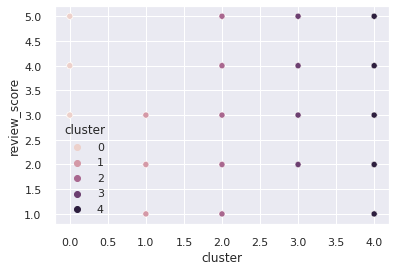

In [63]:
sns.scatterplot(data = rfm_rev, x = "cluster", y = "review_score", hue = "cluster")

In [64]:
display(cluster_count)

Recency           Frequency             Monetary                   \
               mean  min  max      mean min max         mean     min      max   
cluster                                                                         
0        163.035757    0  300  1.000000   1   1   104.711139    0.85   650.00   
1        257.020717   20  734  1.000000   1   1   107.910085    0.85   730.00   
2        268.471553   35  730  1.071758   1   4  1126.729692  599.65  7388.00   
3        433.720563  297  736  1.000000   1   1   105.422025    2.29   689.99   
4        254.120717   34  721  2.225830   2  14   210.919404   11.98  1535.40   

               review_score                 
         count         mean min max  count  
cluster                                     
0        40999     4.712944   3   5  40999  
1        15639     1.748194   1   3  15639  
2         1951     4.213737   1   5   1951  
3        30064     4.636675   2   5  30064  
4         5575     4.222960   1   5   5575

- Le cluster 0 contient 30086 clients. Ils ont peu achété et ont également dépensé peu d'argent. Cependant ils ont commandé recemment, ce sont des clients d'avenir. Ce cluster de clients serait une bonne cible pour une campagne marketing. 

- Le cluster 1 contient 40994 clients ayant peu achétés, ayant peu dépensés et n'ayant pas commandé des produits depuis longtemps . Malgré leur avis positifs, ce sont des clients perdus.

- Le cluster 2 comprend 5575 clients qu'on pourrait qualifier d'insatisfaits. Il ont peu dépensé et peu commandé. Ils ont fait des achats recemment mais leur avis laisse présager qu'ils pourraient ne plus en refaire. Il faudrait retrouver leur satisfaction avec des promotions par exemple.

- Le cluster 3 contient 15622 clients. Ce sont des excellents clients. Il contient les clients les plus dépensiers et ce sont les clients qu'il faut garder à tout prix.

- Le cluster 4 contient 1951 clients qui ont peu dépensé mais étant les plus fidèles. Ce sont donc de très bons clients qu'il faut aussi garder.

In [65]:
cluster_1 = rfm_rev.loc[rfm_rev['cluster'] == 1].sample(1000)
cluster_0 = rfm_rev.loc[rfm_rev['cluster'] == 0].sample(1000)
cluster_3 = rfm_rev.loc[rfm_rev['cluster'] == 3].sample(1000)
cluster_4 = rfm_rev.loc[rfm_rev['cluster'] == 4].sample(1000)
cluster_2 = rfm_rev.loc[rfm_rev['cluster'] == 2].sample(1000)

In [66]:
cluster = pd.concat([cluster_0, cluster_1], axis = 0)
cluster = pd.concat([cluster, cluster_2], axis = 0)
cluster = pd.concat([cluster, cluster_3], axis = 0)
cluster = pd.concat([cluster, cluster_4], axis = 0)

In [67]:
rfm_scaled = pd.DataFrame()
rfm_scaled = rfm_rev.copy()

scaler = StandardScaler()

rfm_scaled[['Recency', 'Frequency','Monetary']] = scaler.fit_transform(
    rfm_scaled[['Recency', 'Frequency','Monetary']])
rfm_scaled['cust_id'] = rfm_rev.index

rfm_melted = pd.melt(frame = rfm_scaled,
                     id_vars= ['cust_id', 'cluster'], 
                     var_name = 'metrics', value_name = 'value')
rfm_melted.head()

,cust_id,cluster,metrics,value
0,0000366f3b9a7992bf8c76cfdf3221e2,0,Recency,-0.781476
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,Recency,-0.741931
2,0000f46a3911fa3c0805444483337064,3,Recency,1.894403
3,0000f6ccb0745a6a4b88665a16c9f078,3,Recency,0.510328
4,0004aac84e0df4da2b147fca70cf8255,3,Recency,0.338966


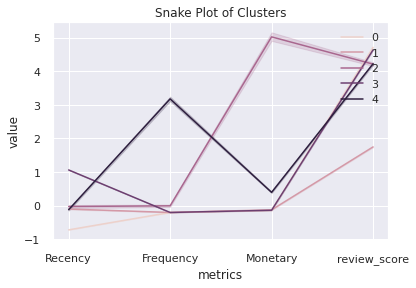

In [68]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'cluster', data = rfm_melted)
plt.title('Snake Plot of Clusters')
plt.legend(loc = 'upper right')

On va faire une visualisation [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 

TSNE est une technique de réduction de dimensionnalité qui est non-linéaire.

In [69]:
from sklearn.manifold import TSNE # TSNE module
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 2000)
tsne_results = tsne.fit_transform(cluster)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 0.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 13.422687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.093536
[t-SNE] KL divergence after 2000 iterations: 0.555039


In [70]:
#creating a new dataframe including target
target = cluster['cluster']
new_df_tsne = pd.DataFrame(np.hstack((tsne_results,
                                      np.array(target).reshape(-1,1))),
                           columns=['1st_component','2nd_component','Cluster'])
new_df_tsne.head()

,1st_component,2nd_component,Cluster
0,18.525341,-71.469467,0.0
1,-1.772397,-21.566816,0.0
2,9.365567,-9.321906,0.0
3,36.733177,-38.407768,0.0
4,-2.063855,-12.509379,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


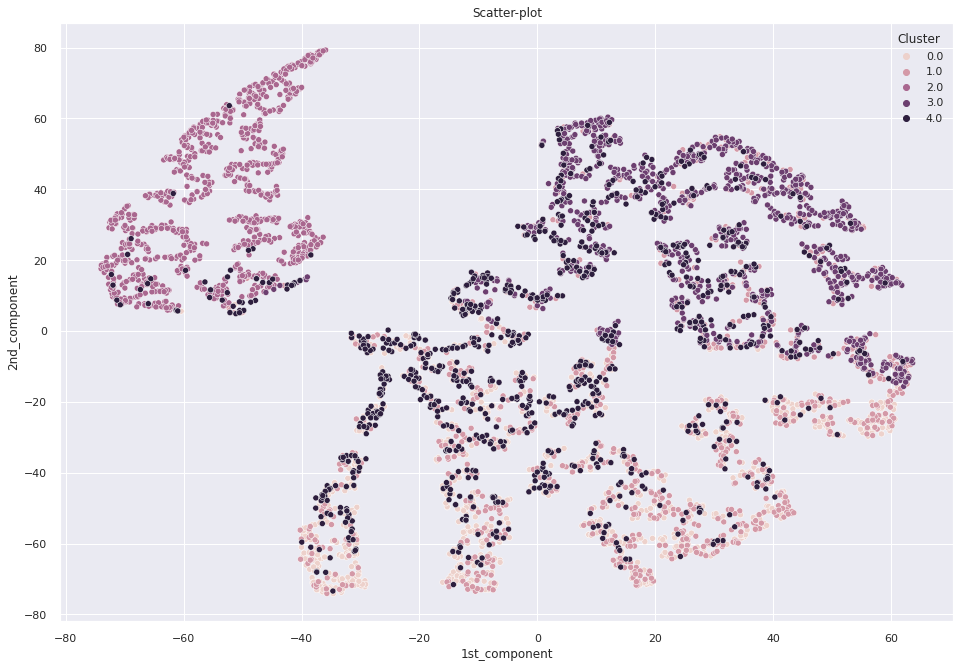

In [71]:
plt.figure(figsize = (16,11))
sns.scatterplot(new_df_tsne['1st_component'],
                new_df_tsne['2nd_component'],hue=new_df_tsne['Cluster'])
plt.title('Scatter-plot')
plt.show()

## *DBSCAN avec RFM plus review_score*

In [72]:
X1= rfm_segmentation[['Recency','Frequency','Monetary','review_score']]
X1= StandardScaler().fit_transform(X1)
from sklearn import metrics

In [73]:
from sklearn.datasets import make_blobs



centers = [[1, 1], [-1, -1], [1, -1]]
X1, labels_true = make_blobs(n_samples = 750, centers = centers,
                             cluster_std = 0.4, random_state = 0)

On utilise ici la [méthode du coude](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc) pour déterminer epsilon. Quant au [min_samples](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd), il est égal à minimum au double du nombre de features.

In [74]:
from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt

In [75]:
neighbors = NearestNeighbors(n_neighbors = 2)

neighbors_fit = neighbors.fit(X1)

distances, indices = neighbors_fit.kneighbors(X1)

Le nombre epsilon idéal est de 0.15

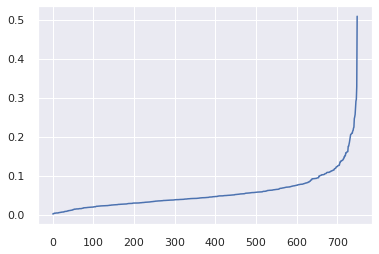

In [76]:
distances = np.sort(distances, axis=0)

distances = distances[:,1]

plt.plot(distances)

Estimated number of clusters: 5
Estimated number of noise points: 129
Homogeneity: 0.828
Completeness: 0.630
V-measure: 0.715
Adjusted Rand Index: 0.702
Adjusted Mutual Information: 0.714
Silhouette Coefficient: 0.342


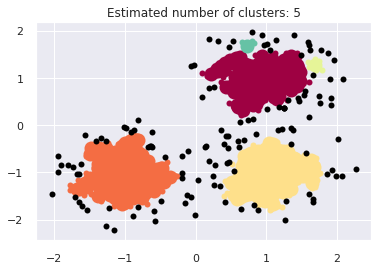

In [77]:
#Application de DBSCAN

db = DBSCAN(eps = 0.15, min_samples = 6).fit(X1)
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Nombre de clusters dans les labels, on ignore le bruit.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X1, labels))

# Plot le résultat
import matplotlib.pyplot as plt
%matplotlib inline

# Couleur noire utilisée pour le bruit.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X1[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor ='k', markersize = 14)

    xy = X1[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col),
             markeredgecolor = 'k', markersize = 6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Ici, le coefficient de silouhette est plus faible de 0.14 sur la méthode DBSCAN comparé au KMeans, KMeans est donc plus adapté pour RFM + review_score.

<a name="Cb"></a>
# **4. Algorithmes de segmentation avec plus de variables**

## *K-means avec plus de variables*

In [78]:
data = pd.merge(data,rfm_segmentation, how='inner',left_on=['customer_unique_id'], right_on=['customer_unique_id'])

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101202 entries, 0 to 101201
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   customer_unique_id             101202 non-null  object  
 1   customer_state                 101202 non-null  object  
 2   harvesine_distance             101202 non-null  float64 
 3   order_id                       101202 non-null  object  
 4   order_delivered_customer_date  101202 non-null  object  
 5   review_score_x                 101202 non-null  int64   
 6   payment_sequential             101202 non-null  int64   
 7   payment_type                   101202 non-null  object  
 8   payment_installments           101202 non-null  int64   
 9   payment_value                  101202 non-null  float64 
 10  product_id                     101202 non-null  object  
 11  seller_id                      101202 non-null  object  
 12  price           

In [80]:
data = data.drop(columns = ['price','date','TotalCost','payment_value',
                        'order_delivered_customer_date','recency_score',
                        'frequency_score','monetary_score','product_photos_qty',
                        'payment_installments'])

In [81]:
data = data.drop(columns=['review_score_y'])
data=data.rename(columns={"review_score_x": "review_score"})
data_test = data.select_dtypes(include=['int64','float64'])

In [82]:
outlier_bis = data.loc[data['Recency'] >= 10000]
data = data.drop(outlier_bis.index)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101202 entries, 0 to 101201
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   customer_unique_id            101202 non-null  object 
 1   customer_state                101202 non-null  object 
 2   harvesine_distance            101202 non-null  float64
 3   order_id                      101202 non-null  object 
 4   review_score                  101202 non-null  int64  
 5   payment_sequential            101202 non-null  int64  
 6   payment_type                  101202 non-null  object 
 7   product_id                    101202 non-null  object 
 8   seller_id                     101202 non-null  object 
 9   product_weight_g              101202 non-null  float64
 10  product_category_name_french  101202 non-null  object 
 11  volume                        101202 non-null  float64
 12  delay                         101202 non-nul

In [84]:
data.describe()

,harvesine_distance,review_score,payment_sequential,product_weight_g,volume,Recency,Frequency,Monetary,score
count,101202.000000,101202.000000,101202.000000,101202.000000,101202.000000,101202.000000,101202.000000,101202.000000,101202.000000
mean,444.026367,4.165175,1.023428,2090.025409,15111.978066,270.602873,1.196340,142.821653,9.241408
std,378.501513,1.279070,0.225398,3746.177073,23146.879555,151.457450,0.808539,208.098796,2.648391
min,0.328117,1.000000,1.000000,0.000000,168.000000,0.000000,1.000000,0.850000,3.000000
25%,211.546343,4.000000,1.000000,300.000000,2816.000000,150.000000,1.000000,46.400000,7.000000
50%,306.973614,5.000000,1.000000,700.000000,6400.000000,249.000000,1.000000,89.000000,9.000000
75%,507.288840,5.000000,1.000000,1800.000000,18000.000000,378.000000,1.000000,157.900000,11.000000
max,5392.902765,5.000000,17.000000,40425.000000,296208.000000,736.000000,14.000000,7388.000000,15.000000


In [85]:
data_num = data.select_dtypes(include=['int64','float64'])

scaler = StandardScaler()
x_scaled_bis = scaler.fit(data_num)
x_scaled_bis = scaler.fit_transform(data_num)

La méthode du coude nous retourne k = 6

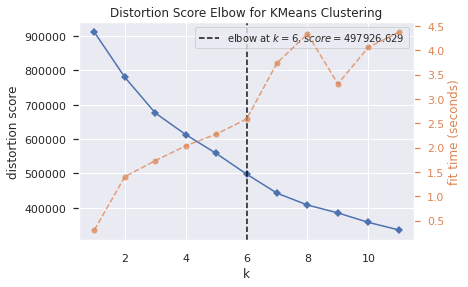

In [86]:
model = KMeans()

visualizer = KElbowVisualizer(model, k = (1,12))

visualizer.fit(x_scaled_bis)  

visualizer.show()   

[2 2 2 ... 0 0 0]
 Our cluster centers are as follows
[[-0.29818176  0.03141187  0.01726333 -0.23335106 -0.19136844  0.7790683
  -0.18077296 -0.28444767 -0.82662965]
 [-0.07579397 -0.1228256   0.01652896  2.91395064  2.68910139  0.02661237
  -0.00683744  1.20411857  0.52336516]
 [ 2.53261102 -0.14521335  0.02601435 -0.18426534 -0.18335031  0.01462062
  -0.030742    0.06668965  0.03787179]
 [-0.30992562  0.0245289  -0.02380129 -0.19599217 -0.19899818 -0.69639858
   0.16801106  0.05228128  0.64235398]]


,harvesine_distance,review_score,payment_sequential,product_weight_g,volume,Recency,Frequency,Monetary,score
cluster_pred,,,,,,,,,
0,39490,39490,39490,39490,39490,39490,39490,39490,39490
1,6808,6808,6808,6808,6808,6808,6808,6808,6808
2,10311,10311,10311,10311,10311,10311,10311,10311,10311
3,44593,44593,44593,44593,44593,44593,44593,44593,44593


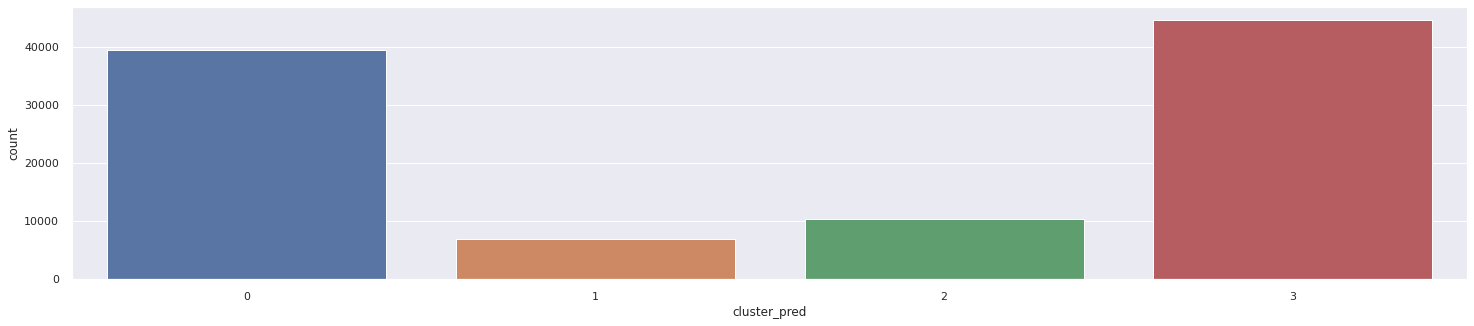

In [87]:
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled_bis)
identified_clusters = kmeans_scaled.fit_predict(data_num)

clusters_scaled = data_num.copy()
clusters_scaled['cluster_pred'] = kmeans_scaled.fit_predict(x_scaled_bis)
print(identified_clusters)
sns.set(style = "darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)

f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

In [88]:
# Silhouette 
range_n_clusters = [ 3, 4, 5]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter = 50)
    kmeans.fit(x_scaled_bis)
    
    
    # silhouette score
    silhouette_avg = silhouette_score(x_scaled_bis, kmeans.labels_)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters,
                                                              silhouette_avg))

For n_clusters=3, the silhouette score is 0.19041900750318644
For n_clusters=4, the silhouette score is 0.20977560217470836
For n_clusters=5, the silhouette score is 0.21732685655408837


Silhouette Score: 0.210


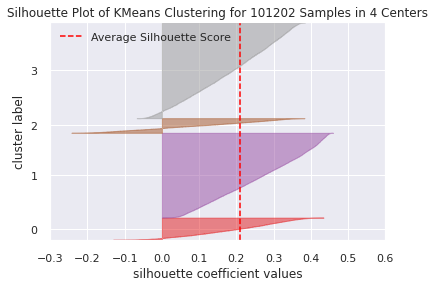

In [89]:
sil_score = silhouette_score(x_scaled_bis, kmeans_scaled.labels_,
                             metric = 'euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled_bis)   
visualizer.poof()   

Silhouette Score: 0.210


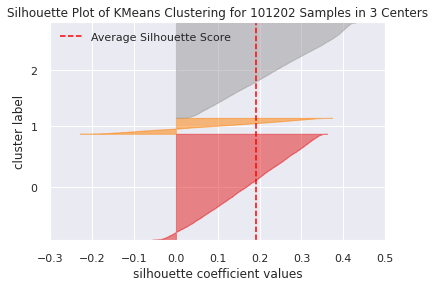

In [90]:
sil_score = silhouette_score(x_scaled_bis, kmeans_scaled.labels_,
                             metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled_bis)   
visualizer.poof()   

In [91]:
range_n_clusters = [3, 4, 5]

for num_clusters in range_n_clusters:
    
    #intialisation de kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(x_scaled_bis)
    
    
    #silhouette score
    davies_avg = davies_bouldin_score(x_scaled_bis, kmeans.labels_)
    print("For n_clusters={0}, the davies_bouldin score is {1}".format(
                                                          num_clusters, 
                                                          round(davies_avg,2)))

For n_clusters=3, the davies_bouldin score is 1.67
For n_clusters=4, the davies_bouldin score is 1.48
For n_clusters=5, the davies_bouldin score is 1.32


Le nombre optimal de clusters est de 4.

Cependant, nos métriques retournent de mauvais scores comparé à la segmentation RFM + review_score , on va aller au bout de la segmentation KMeans mais elle ne sera pas utilisée par la suite. 

In [92]:
data_num['cluster']= clusters_scaled['cluster_pred']


cluster_group = data_num.groupby('cluster').agg({
    'Recency' : ['mean','min','max'],
    'Frequency' : ['mean','min','max'],
    'Monetary' : ['mean','min','max','count']
})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


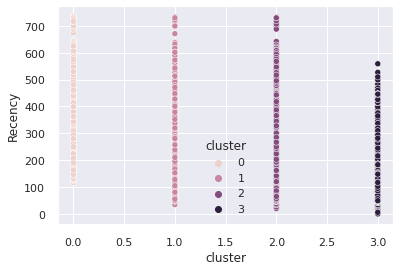

In [93]:
sns.scatterplot(data=data_num, x="cluster", y="Recency", hue="cluster")

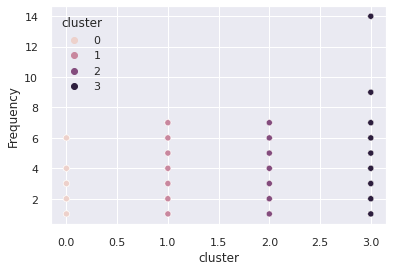

In [94]:
sns.scatterplot(data=data_num, x="cluster", y="Frequency", hue="cluster")

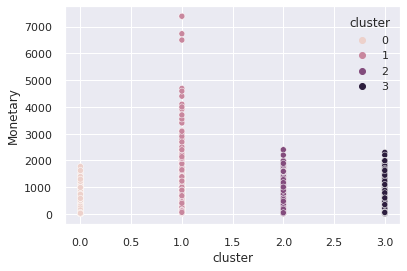

In [95]:
sns.scatterplot(data=data_num, x="cluster", y="Monetary", hue="cluster")

In [96]:
data_num.groupby(['cluster']).size()

cluster
0    39490
1     6808
2    10311
3    44593
dtype: int64

In [97]:
data_num.head()

,harvesine_distance,review_score,payment_sequential,product_weight_g,volume,Recency,Frequency,Monetary,score,cluster
0,361.006047,4,1,8683.0,107136.0,510,1,124.99,8,1
1,960.287330,4,1,8683.0,107136.0,245,1,126.99,9,1
2,202.794320,4,1,8683.0,107136.0,303,1,112.99,8,1
3,348.729613,3,1,8683.0,107136.0,197,1,116.99,12,1
4,396.113519,5,1,8683.0,107136.0,519,1,124.99,6,1


In [98]:
rfm_scaled=pd.DataFrame()

rfm_scaled=data_num.copy()

scaler=StandardScaler()

rfm_scaled[['Recency', 'Frequency','Monetary','review_score','product_weight_g',
            'volume','harvesine_distance','score']] = scaler.fit_transform(
                rfm_scaled[['Recency', 'Frequency','Monetary','review_score',
                            'product_weight_g','volume','harvesine_distance',
                            'score']])
rfm_scaled['cust_id'] = data_num.index
rfm_melted = pd.melt(frame = rfm_scaled, id_vars = ['cust_id','cluster'],
                     var_name = 'metrics', value_name = 'value')
rfm_melted.head()

,cust_id,cluster,metrics,value
0,0,1,harvesine_distance,-0.219341
1,1,1,harvesine_distance,1.363967
2,2,1,harvesine_distance,-0.637338
3,3,1,harvesine_distance,-0.251775
4,4,1,harvesine_distance,-0.126586


On observe ci-dessous une relation flagrante entre le volume des produits et la catégorie de clients.

On pourrait faire la théorie que ceci est relié au prix des produits : plus le produit est volumineux, plus le produit et sa livraison sont chers, plus le client dépense. 

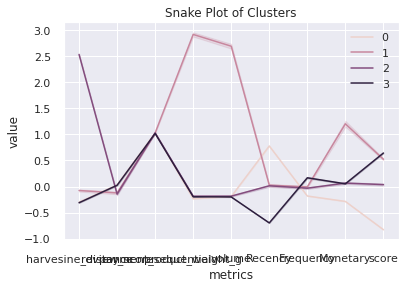

In [99]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'cluster', data = rfm_melted)

plt.title('Snake Plot of Clusters')
plt.legend(loc = 'upper right')

## *DBSCAN avec plus de variables* : 

In [100]:
X2 = data.select_dtypes(include=['int64','float64'])

X2.to_csv("/content/drive/MyDrive/X2.csv")

X2 = StandardScaler().fit_transform(X2)

from sklearn import metrics

In [101]:
from sklearn.datasets import make_blobs



centers = [[1, 1], [-1, -1], [1, -1]]
X2, labels_true = make_blobs(n_samples = 750, centers = centers, 
                             cluster_std = 0.4,random_state = 0)

In [102]:
neighbors = NearestNeighbors(n_neighbors = 2)

neighbors_fit = neighbors.fit(X2)

distances, indices = neighbors_fit.kneighbors(X2)

Epsilon a pour valeur idéale de 0.15 selon le graphique ci-dessous.

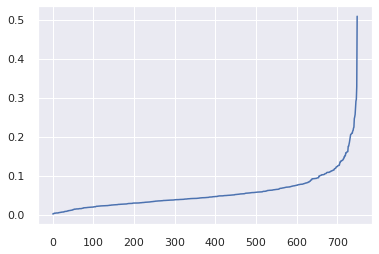

In [103]:
distances = np.sort(distances, axis = 0)

distances = distances[:,1]

plt.plot(distances)

Estimated number of clusters: 5
Estimated number of noise points: 459
Homogeneity: 0.388
Completeness: 0.337
V-measure: 0.361
Adjusted Rand Index: 0.097
Adjusted Mutual Information: 0.357
Silhouette Coefficient: -0.181


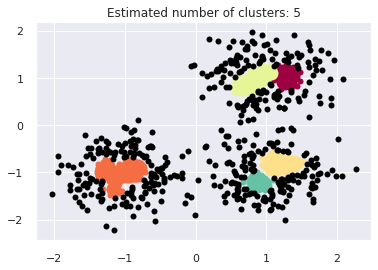

In [104]:
db = DBSCAN(eps = 0.15, min_samples = 18).fit(X2)
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X2, labels))

import matplotlib.pyplot as plt
%matplotlib inline


unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
  
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X1[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col),
             markeredgecolor = 'k', markersize = 14)

    xy = X1[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col),
             markeredgecolor = 'k', markersize = 6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Le coefficient de Silhouette est faible. DBSCAN n'est pas optimal dans ce cas de figure.

## Conclusion :

Premièrement, nos silhouettes scores sont tous faibles (valeur maximum de 0.49 sur toutes les segmentations utilisées ici) donc dans l'ensemble la performance de notre clustering est relativement pauvre donc il s'agit ici de choisir la segmentation la "moins mauvaise". 

On va choisir la segmentation KMeans car dans ce cas, un algorithme de densification comme DBSCAN a ses limites. Parmis les bons clients, on remarque beaucoup de différences et on a du mal a retrouver une densité d'utilisateurs.

KMeans est plus adapté ici car c'est un algorithme de partition et c'est avec les variables Kmeans plus review_score qu'on obtient les meilleures métriques (Silhouette Score, Davies-Bouldin Score, Elbow). Cependant, les performances sont limitées ( silhouette score de 0.45)

Les clusters qu'on retrouve sont donc :          

- Cluster 0 : Clients d'avenir (faire preuve de patience?)

- Cluster 1 : Clients perdus 

- Cluster 2 : Clients insatisfaits ( Investigation sur les causes )

- Cluster 3 : Excellents clients (les plus dépensiers, à récompenser )

- Cluster 4 : Clients les plus fidèles ( à récompenser aussi, clients importants)